In [47]:
# Initialize Otter
import otter
grader = otter.Notebook("hw12.ipynb")

<img src="data8logo.png" alt="Data 8 Logo" style="width: 15%; float: right; padding: 1%; margin-right: 2%;"/>

# Homework 12: Classification

**Helpful Resource:**

- [Python Reference](http://data8.org/fa24/reference/): Cheat sheet of helpful array & table methods used in Data 8!

**Recommended Reading**: 

* [Classification](https://www.inferentialthinking.com/chapters/17/Classification.html)
* [Updating Predictions](https://inferentialthinking.com/chapters/18/Updating_Predictions.html)

Please complete this notebook by filling in the cells provided. **Before you begin, execute the cell below to setup the notebook by importing some helpful libraries.** Each time you start your server, you will need to execute this cell again.

For all problems that you must write explanations and sentences for, you **must** provide your answer in the designated space. Moreover, throughout this homework and all future ones, **please be sure to not re-assign variables throughout the notebook!** For example, if you use `max_temperature` in your answer to one question, do not reassign it later on. Otherwise, you will fail tests that you thought you were passing previously!

**Deadline:**

This assignment is **due Tuesday, 11/26 at 5:00pm PT**. Submissions after this time will be accepted for 24 hours and will incur a 20% penalty. Any submissions later than this 24 hour period will not be accepted unless an extension has been granted as per the [policies](http://data8.org/fa24/policies/) page. Turn it in by Monday, 11/25 at 5:00pm PT for 5 extra credit points.

<span style="color:red">**Note: This homework has hidden tests on it. That means even though tests may say 100% passed, it doesn't mean your final grade will be 100%. We will be running more tests for correctness once everyone turns in the homework.**</span>

Directly sharing answers is not okay, but discussing problems with the course staff or with other students is encouraged. Refer to the [policies](http://data8.org/fa24/policies/#learning-cooperatively) page to learn more about how to learn cooperatively.

You should start early so that you have time to get help if you're stuck. Office hours are held Monday through Friday in [Warren Hall](https://www.berkeley.edu/map?warren) 101B. The office hours schedule appears [here](http://data8.org/fa24/schedule/).

---

The point breakdown for this assignment is given in the table below:
| Category | Points |
| --- | --- |
| Autograder (Coding questions) | 76 |
| Written | 24 |
| **Total** | 100 |

In [48]:
# Don't change this cell; just run it. 

import numpy as np
from datascience import * 

# These lines do some fancy plotting magic
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore')
from datetime import datetime

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

### Classifier Primer

Though it is ungraded, we **highly reccomend** you complete this quick [classifier primer](https://docs.google.com/forms/d/e/1FAIpQLSeTrGYhdp-CPemw-T20eMMVEGkEaYampKndi8qKMlHjBwR0yQ/viewform?usp=sf_link) before completing this homework assignment.

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## 1. Bay Area School Coordinates with Classification

Welcome to Homework 12! This homework is about k-Nearest Neighbors classification (k-NN). Since this topic is covered in depth in Project 3, the purpose of this homework is to reinforce the basics of this method. You can and should reuse a lot of code that you wrote for Project 3 for this homework, or use code from this homework on Project 3!

### Our Dearest Neighbors

Edwin is trying classify students as either attendees of UC Berkeley or as attendees of Stanford University. To classify the students, Edwin has access to the coordinates of the location they live during the school year. First, load in the `coordinates` table.

In [49]:
# Just run this cell!
coordinates = Table.read_table('coordinates.csv')
coordinates.show(5)

latitude,longitude,school
37.8693,-122.255,Berkeley
37.8651,-122.256,Berkeley
37.8661,-122.254,Berkeley
37.868,-122.26,Berkeley
37.8683,-122.257,Berkeley


As usual, let's investigate our data visually before performing any kind of numerical analysis.

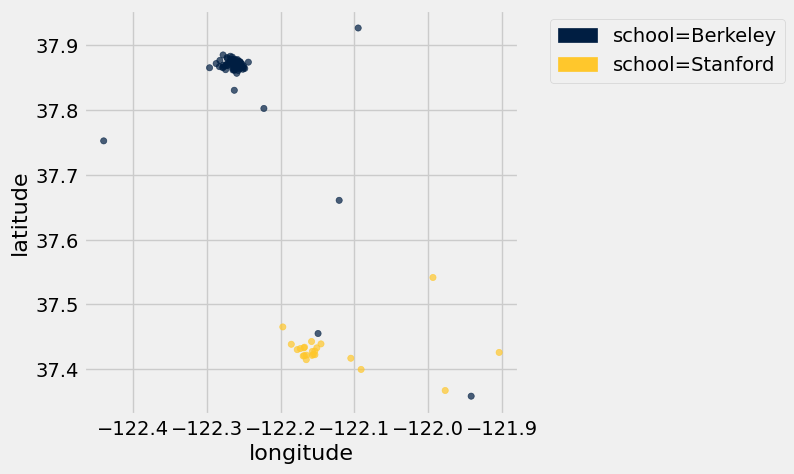

In [50]:
# Just run this cell!
coordinates.scatter("longitude", "latitude", group="school")

The locations of the points on this scatter plot might be familiar - run the following cell to see what they correspond to.

In [51]:
# Just run this cell!
colors = {"Berkeley":"blue", "Stanford":"red"}
t = Table().with_columns("lat", coordinates.column(0), 
                                      "lon", coordinates.column(1), 
                                      "color", coordinates.apply(colors.get, 2)
                        )
Circle.map_table(t, radius=5, fill_opacity=1)

---

**Question 1.1.1** Let's begin implementing the k-Nearest Neighbors algorithm. Define the `distance` function, which takes in two arguments: an array of numerical features (`arr1`), and a different array of numerical features (`arr2`). The function should return the [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between the two arrays. Euclidean distance is often referred to as the straight-line distance formula. **(6 points)**

*Note:* Features refer to the characteristics of data used for machine learning models to predict with. In table format, these are the columns.

In [52]:
def distance(arr1, arr2):
    return np.sqrt(np.sum((arr1-arr2)**2))

# Don't change/delete the code below in this cell
distance_example = distance(make_array(1, 2, 3), make_array(4, 5, 6))
distance_example

5.196152422706632

In [53]:
grader.check("q1_1_1")

q1_1_1 results: All test cases passed!

<!-- BEGIN QUESTION -->

---

**Question 1.1.2** While Euclidean distance is a more commonly known method to measure distance, it’s not the only one! Another method is the [Manhattan distance](https://simple.wikipedia.org/wiki/Manhattan_distance). How do we calculate the Manhattan distance between two points? What situation might Manhattan distance be more suitable than Euclidean distance? **(4 points)**

*Hint:* Consider why it’s named _Manhattan distance_—think of a city grid!

Khoảng cách Manhattan bằng tổng trị tuyệt đối của các hiệu tọa độ 
- Nó hợp lí sử dụng khi bạn muốn tính khoảng cách khi bị giới hạn theo dạng lưới 

<!-- END QUESTION -->

---

### Splitting the Dataset
We'll do two different kinds of things with the `coordinates` dataset:

1. We'll build a classifier using coordinates for which we know the associated label; this will teach it to recognize labels of similar coordinate values. This process is known as *training*.
2. We'll evaluate or *test* the accuracy of our classifier on data we haven't seen before.

As discussed in [Section 17.2](https://inferentialthinking.com/chapters/17/2/Training_and_Testing.html#training-and-testing), we want to use separate datasets for training and testing. As such, we split up our one dataset into two.

---

**Question 1.2.** Next, let's split our dataset into a training set and a test set. Since `coordinates` has 100 rows, let's create a training set with the first 75 rows and a test set with the remaining 25 rows. Remember that assignment to each group should be random, so we should shuffle the table first. **(10 points)**

*Hint:* As a first step we can shuffle all the rows, then use the `tbl.take` function to split up the rows for each table.


In [54]:
shuffled_table = coordinates.shuffle()
train = shuffled_table.take(np.arange(75))
test = shuffled_table.take(np.arange(75,100))

print("Training set:\t",   train.num_rows, "examples")
print("Test set:\t",       test.num_rows, "examples")
train.show(5), test.show(5);

Training set:	 75 examples
Test set:	 25 examples


latitude,longitude,school
37.868,-122.254,Berkeley
37.432,-122.173,Stanford
37.3587,-121.942,Berkeley
37.4304,-122.177,Stanford
37.8779,-122.262,Berkeley


latitude,longitude,school
37.4211,-122.168,Stanford
37.8672,-122.263,Berkeley
37.8663,-122.257,Berkeley
37.8688,-122.255,Berkeley
37.9261,-122.095,Berkeley


In [55]:
grader.check("q1_2")

q1_2 results: All test cases passed!

---

**Question 1.3.** Assign `features` to an array of column names (strings) of the features from the `coordinates` table. **(10 points)**

*Hint:* Which of the column names in the `coordinates` table are the features, and which of the column names correspond to the class we're trying to predict?

*Hint*: No need to modify any tables, just manually create an array of the feature names!


In [56]:
features = np.array(coordinates.labels[:-1])
features

array(['latitude', 'longitude'],
      dtype='<U9')

In [57]:
grader.check("q1_3")

q1_3 results: All test cases passed!

---

**Question 1.4.** Now define the `classify` function. This function should take in a `test_row` from a table like `test` and classify it using the k-Nearest Neighbors based on the correct `features` and the data in `train`. A refresher on k-Nearest Neighbors can be found [here](https://www.inferentialthinking.com/chapters/17/4/Implementing_the_Classifier.html). **(10 points)**


*Hint 1:* The `distance` function we defined earlier takes in arrays as input, so use the `row_to_array` function we defined for you to convert rows to arrays of features.

*Hint 2:* The skeleton code we provided iterates through each row in the training set. `train_row` is a row object.


In [58]:
def row_to_array(row, features):
    """Converts a row to an array of its features."""
    arr = make_array()
    for feature in features:
        arr = np.append(arr, row.item(feature))
    return arr

def classify(test_row, k, train):
    test_row_features_array = row_to_array(test_row, features)
    distances = make_array()
    for train_row in train.rows:
        train_row_features_array = row_to_array(train_row,features)
        row_distance = np.sqrt(np.sum((train_row_features_array-test_row_features_array)**2))
        distances = np.append(distances,row_distance)
    train_with_distances = train.with_columns(
        "Distances", distances
    )
    nearest_neighbors = train_with_distances.sort("Distances").take(np.arange(k))
    most_common_label = nearest_neighbors.group('school').sort('count', descending=True).column('school').item(0)
    return most_common_label

# Don't modify/delete the code below
first_test = classify(test.row(0), 5, train)
first_test

'Stanford'

In [59]:
grader.check("q1_4")

q1_4 results: All test cases passed!

---

**Question 1.5.** Define the function `three_classify` that takes a `row` from `test` as an argument and classifies the row based on using 3-Nearest Neighbors. Use this function to find the `accuracy` of a 3-NN classifier on the `test` set. `accuracy` should be a proportion (not a percentage) of the schools that were correctly predicted. **(10 points)**


*Hint:* You should be using a function you just created!

*Note:* Usually before using a classifier on a test set, we'd classify first on a "validation" set, which we then can modify our training set again if need be, before actually testing on the test set. You don’t need to do that for this question, but you will learn about this more in Data 100.


In [60]:
def three_classify(row):
    return classify(row, 3, train)

test_with_prediction = test.apply(three_classify)
accuracy = np.count_nonzero(test_with_prediction == test.column("school"))/ len(test_with_prediction)
accuracy

1.0

In [61]:
grader.check("q1_5")

q1_5 results: All test cases passed!

---

**Question 1.6.** There are 77 rows of Berkeley students and 23 rows of Stanford students in the `coordinates` table. If we used the entire `coordinates` table as the training set, what is the smallest value of k that would ensure that a k-Nearest Neighbor classifier would *always* predict Berkeley as the class? Assign the value to `k`. **(10 points)**

> **Note:** Section [17.2](https://inferentialthinking.com/chapters/17/2/Training_and_Testing.html) from the textbook may be useful here!

In [62]:
k = 47
k

47

In [63]:
grader.check("q1_6")

q1_6 results: All test cases passed!

<!-- BEGIN QUESTION -->

---

**Question 1.7.1** When doing Knn classification we split our data into training and test sets.

Why do we divide our data into training and test sets? Or in other words what is the point of the training set? What is the point of the test set? Answer both questions. **(7 points)**

> *Hint:* Check out this [section](https://inferentialthinking.com/chapters/17/2/Training_and_Testing.html) in the textbook.


Giúp bạn đánh giá Knn của bạn tốt tới mức nào :
- Train để giúp bạn có thể dự đoán về các nhãn tại test 
- Test để đánh giá độ chính xác của K-nn từ nhãn đúng và nhãn được dự đoán tại train 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

---

**Question 1.7.2** Why do we only want to use the test set once? **(3 points)**

Để chúng ta đánh giá một cách đúng nhất về độ chính xác của K-nn nếu dùng đi dùng lại nhiều lần thì chúng ta đang chỉ cố có tỉ lệ đúng cao so với các ví dụ ở tập test chứ ko phải tổng thể


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

---

**Question 1.8.** Why do we choose `k` to be an odd number in k-NN? Explain. **(10 points)**

Việc chọn K lẻ giúp k-NN tránh trường hợp bị hòa nhãn hơn , đảm bảo đưa ra kết quả chính xác hơn

<!-- END QUESTION -->

---

**Question 1.9.0. Setup**

Thomas has devised a scheme for splitting up the test and training set. For each row from `coordinates`:
- Rows for Stanford students have a 50% chance of being placed in the training set and 50% chance of being placed in the test set.  
- Rows for Berkeley students have a 80% chance of being placed in the training set and 20% chance of being placed in the test set.  


*Hint 1:* Remember that there are 77 Berkeley students and 23 Stanford students in coordinates.  

*Hint 2:* [18.1](https://inferentialthinking.com/chapters/18/1/More_Likely_than_Not_Binary_Classifier.html#bayes-rule) from the textbook may be helpful here!

---

**Question 1.9.1.** Given that a row is in the test set, what is the probability that it corresponds to a Stanford student? Assign that probability to `prob_furd`. **(10 points)**

> ***Note:*** **Do not round this value; calculate it exactly.**

In [64]:
prob_furd = 0.5*0.23/(0.77*0.2 + 0.5*0.23)
prob_furd

0.4275092936802974

In [65]:
grader.check("q1_9_1")

q1_9_1 results: All test cases passed!

---

**Question 1.9.2.** Given that a row is Stanford, what is the probability that the student is in the test set? Assign that probability to `prob_test`. **(10 points)**


In [66]:
prob_test = 0.5
prob_test

0.5

In [67]:
grader.check("q1_9_2")

q1_9_2 results: All test cases passed!

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## (OPTIONAL, NOT IN SCOPE): k-NN for Non-Binary Classification

**THIS IS NOT IN SCOPE**. There are no autograder tests for this or code for you to write. It just relies on the function `classify` in Question 1.4. Go ahead and read through this section and run the following cells!

In this class, we have taught you how to use the k-NN algorithm to classify data as one of two classes. However, much of the data you will encounter in the real world will not fall nicely into one of two categories. 

**How can we classify data with non-binary classes?** It turns out we can still use k-NN! That is, we find the distance between a point and all its neighbors, find the nearest neighbors, and take a majority vote among the neighbors to determine this point's class. 

The only difference is that now the neighboring points have more than two possible classes. This does introduce difficulty because now we have no way of guaranteeing that we will not encounter ties between classes. In the case that we do encounter a tie, we can just arbitrarily choose one of the classes.

In fact, you don't even have to modify the code you wrote before at all to enable multi-class classification!

Let's add some more data to our train table, this time for another class of students, students at San Jose Community College (SJCC).

In [68]:
coordinates_multi = coordinates.with_rows([
                              [37.304346, -121.915401, "SJCC"],
                              [37.316275, -121.913879, "SJCC"],
                              [37.409435, -121.951379, "SJCC"],
                              [37.349387, -121.960771, "SJCC"],
                              [37.329083, -121.928479, "SJCC"],
                              [37.313017, -121.866730, "SJCC"],
                              [37.346525, -121.894767, "SJCC"],
                              [37.364157, -121.955717, "SJCC"],
                              [37.383362, -121.925776, "SJCC"],
                              [37.329545, -121.880639, "SJCC"]                             
])

In [69]:
classify(coordinates_multi.row(0), 5, coordinates_multi)

'Berkeley'

In [70]:
classify(coordinates_multi.row(91), 5, coordinates_multi)

'Stanford'

In [71]:
classify(coordinates_multi.row(105), 5, coordinates_multi)

'SJCC'

Our classifier can classify rows as belonging to one of three classes!

Classification is one of the most important fields in statistics, data science, and machine learning. There are thousands of different classification algorithms and modifications of algorithms! There are many that you'll learn if you continue down the path of becoming a data scientist!

You're all done with Homework 12!

**Important submission steps:** 
1. Run the tests and verify that they all pass.
2. Choose **Save Notebook** from the **File** menu, then **run the final cell**. 
3. Click the link to download the zip file.
4. Go to [Gradescope](https://www.gradescope.com) and submit the zip file to the corresponding assignment. The name of this assignment is "HW 12 Autograder". 

**It is your responsibility to make sure your work is saved before running the last cell.**

## Pets of Data 8

**Snicker's** reaction to realizing the model performed great… on the training data.

<img src="./snickers.jpg" width="40%" alt="Tabby cat looking surprised at the camera"/>

Congrats on finishing Homework 12!

<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## Written Work Submission

Below, you will see two cells. Running the first cell will automatically generate a PDF of all questions that need to be manually graded, and running the second cell will automatically generate a zip with your autograded answers. You are responsible for submitting both the coding portion (the zip) and the written portion (the PDF) to their respective Gradescope portals. **Please save before exporting!**

> **Important: You must correctly assign the pages of your PDF after you submit to the correct gradescope assignment. If your pages are not correctly assigned and/or not in the correct PDF format by the deadline, we reserve the right to award no points for your written work.**

If there are issues with automatically generating the PDF in the first cell, you can try downloading the notebook as a PDF by clicking on `File -> Save and Export Notebook As... -> Webpdf`. If that doesn't work either, you can manually take screenshots of your answers to the manually graded questions and submit one single PDF of your screenshots. Either way, **you are responsible for ensuring your submision follows our requirements, we will NOT be granting regrade requests for submissions that don't follow instructions.**

**You must submit the PDF generated via one of these methods, we will not accept screenshots or Word documents.**

In [72]:
from otter.export import export_notebook
from os import path
from IPython.display import display, HTML
name = 'hw12'
export_notebook(f"{name}.ipynb", filtering=True, pagebreaks=True)
if(path.exists(f'{name}.pdf')):
    display(HTML(f"Download your PDF <a href='{name}.pdf' download>here</a>."))
else:
    print("\n Pdf generation failed, please try the other methods described above")

UnicodeDecodeError: 'charmap' codec can't decode byte 0x8d in position 203836: character maps to <undefined>

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [73]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False, run_tests=True)

Running your submission against local test cases...


Your submission received the following results when run against available test cases:

    q1_1_1 results: All test cases passed!

    q1_2 results: All test cases passed!

    q1_3 results: All test cases passed!

    q1_4 results: All test cases passed!

    q1_5 results: All test cases passed!

    q1_6 results: All test cases passed!

    q1_9_1 results: All test cases passed!

    q1_9_2 results: All test cases passed!
